In [6]:
# --- Interactive plotting for basic dyslexia center data overview --- #
# Import libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
import ipywidgets as widgets
from IPython.display import display, Markdown, Javascript
from IPython.core.display import display, HTML
import regex as re
from enum import Enum, auto

sys.path.append('/Users/mkersey/code/REDCap_tools/')
from redcap_tools.import_data import (import_data_redcap, import_redcap_metadata, import_redcap_report)
from IPython.core.display import display, HTML

sys.path.append('/Users/mkersey/code/neuro_predictor/code')
from neuro_predictor.data_curation import get_diagnosis, get_mri, get_batteries

from ucsfneuroviz.importer import import_dataframe, read_csv_as_list
from ucsfneuroviz.interactive_behav_plots import interactive_heatmap, interactive_radar, interactive_line_plot, interactive_individual_line_plot
from ucsfneuroviz.interactive_brain_plots import interactive_brain_zscore_plot, extract_dc_diagnoses, activate_selected_font
from ucsfneuroviz.fc_vars import FC_vars, FC_vars_select

display(HTML('<link rel="stylesheet" href="style_stats.css">'))

# UCSF Dyslexia Center

update_checkboxes called
HTTP Status: 200
HTTP Status: 200
update_checkboxes called
plot_stats called
Data used for plotting:


,ID Number,Event Name,Survey Identifier,MAC PIDN #:,Date of Birth:,Sex:,"If other sex, please state:",Gender:,"If other gender, please state:",Handedness:,...,Dyslexia Phenotype Short,Dyslexia and ADHD,Dyslexia and Dyscalculia,Dyslexia and MLD,MLD Subtype Primary,MLD Subtype Secondary,MRI Acquired,Math Battery Completed,Primary Phenotyping Battery\n(Pediatric),Primary Control Battery\n(Pediatric)
0,1,Visit One,NaN,1.0,2011-01-01,Male,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
52,16365,Visit One,NaN,16365.0,2004-08-12,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
56,16394,Visit One,NaN,16394.0,2002-04-01,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
60,17065,Visit One,NaN,17065.0,2000-04-15,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
64,17066,Visit One,NaN,17066.0,1998-09-16,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,35071,Visit One,NaN,35071.0,2010-11-12,Male,NaN,Male,NaN,Right,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3611,35117,Visit One,NaN,35117.0,2009-09-24,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3612,35120,Visit One,NaN,35120.0,2012-12-17,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3613,35121,Visit One,NaN,NaN,2014-01-10,Male,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No


Filtered data shape: (574, 4829)
    ID Number Event Name  Survey Identifier  MAC PIDN #: Date of Birth:    \
0           1  Visit One                NaN          1.0       2011-01-01   
52      16365  Visit One                NaN      16365.0       2004-08-12   
56      16394  Visit One                NaN      16394.0       2002-04-01   
60      17065  Visit One                NaN      17065.0       2000-04-15   
64      17066  Visit One                NaN      17066.0       1998-09-16   

      Sex:  If other sex, please state: Gender:  \
0     Male                          NaN  Female   
52  Female                          NaN  Female   
56  Female                          NaN  Female   
60  Female                          NaN  Female   
64  Female                          NaN  Female   

   If other gender, please state: Handedness:  ...  Dyslexia Phenotype Short  \
0                             NaN       Right  ...                       NaN   
52                            NaN    

,ID Number,Event Name,Survey Identifier,MAC PIDN #:,Date of Birth:,Sex:,"If other sex, please state:",Gender:,"If other gender, please state:",Handedness:,...,Dyslexia Phenotype Short,Dyslexia and ADHD,Dyslexia and Dyscalculia,Dyslexia and MLD,MLD Subtype Primary,MLD Subtype Secondary,MRI Acquired,Math Battery Completed,Primary Phenotyping Battery\n(Pediatric),Primary Control Battery\n(Pediatric)
0,1,Visit One,NaN,1.0,2011-01-01,Male,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
52,16365,Visit One,NaN,16365.0,2004-08-12,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
56,16394,Visit One,NaN,16394.0,2002-04-01,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
60,17065,Visit One,NaN,17065.0,2000-04-15,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
64,17066,Visit One,NaN,17066.0,1998-09-16,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,35071,Visit One,NaN,35071.0,2010-11-12,Male,NaN,Male,NaN,Right,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3611,35117,Visit One,NaN,35117.0,2009-09-24,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3612,35120,Visit One,NaN,35120.0,2012-12-17,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3613,35121,Visit One,NaN,NaN,2014-01-10,Male,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No


Filtered data shape: (574, 4829)
    ID Number Event Name  Survey Identifier  MAC PIDN #: Date of Birth:    \
0           1  Visit One                NaN          1.0       2011-01-01   
52      16365  Visit One                NaN      16365.0       2004-08-12   
56      16394  Visit One                NaN      16394.0       2002-04-01   
60      17065  Visit One                NaN      17065.0       2000-04-15   
64      17066  Visit One                NaN      17066.0       1998-09-16   

      Sex:  If other sex, please state: Gender:  \
0     Male                          NaN  Female   
52  Female                          NaN  Female   
56  Female                          NaN  Female   
60  Female                          NaN  Female   
64  Female                          NaN  Female   

   If other gender, please state: Handedness:  ...  Dyslexia Phenotype Short  \
0                             NaN       Right  ...                       NaN   
52                            NaN    

,ID Number,Event Name,Survey Identifier,MAC PIDN #:,Date of Birth:,Sex:,"If other sex, please state:",Gender:,"If other gender, please state:",Handedness:,...,Dyslexia Phenotype Short,Dyslexia and ADHD,Dyslexia and Dyscalculia,Dyslexia and MLD,MLD Subtype Primary,MLD Subtype Secondary,MRI Acquired,Math Battery Completed,Primary Phenotyping Battery\n(Pediatric),Primary Control Battery\n(Pediatric)
0,1,Visit One,NaN,1.0,2011-01-01,Male,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
52,16365,Visit One,NaN,16365.0,2004-08-12,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
56,16394,Visit One,NaN,16394.0,2002-04-01,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
60,17065,Visit One,NaN,17065.0,2000-04-15,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
64,17066,Visit One,NaN,17066.0,1998-09-16,Female,NaN,Female,NaN,Right,...,NaN,Dyslexia and ADHD,Dyslexia Only,NaN,NaN,NaN,Acquired,Not Completed,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,35071,Visit One,NaN,35071.0,2010-11-12,Male,NaN,Male,NaN,Right,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3611,35117,Visit One,NaN,35117.0,2009-09-24,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3612,35120,Visit One,NaN,35120.0,2012-12-17,Female,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No
3613,35121,Visit One,NaN,NaN,2014-01-10,Male,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Not Acquired,Not Completed,No,No


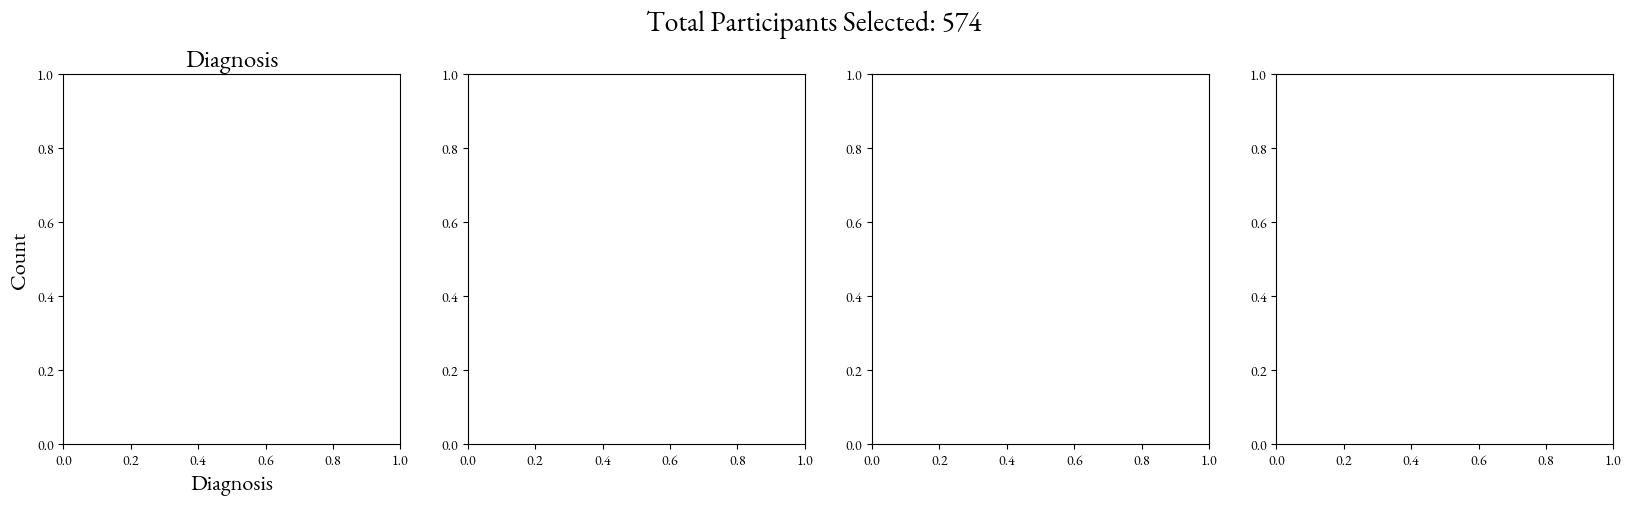

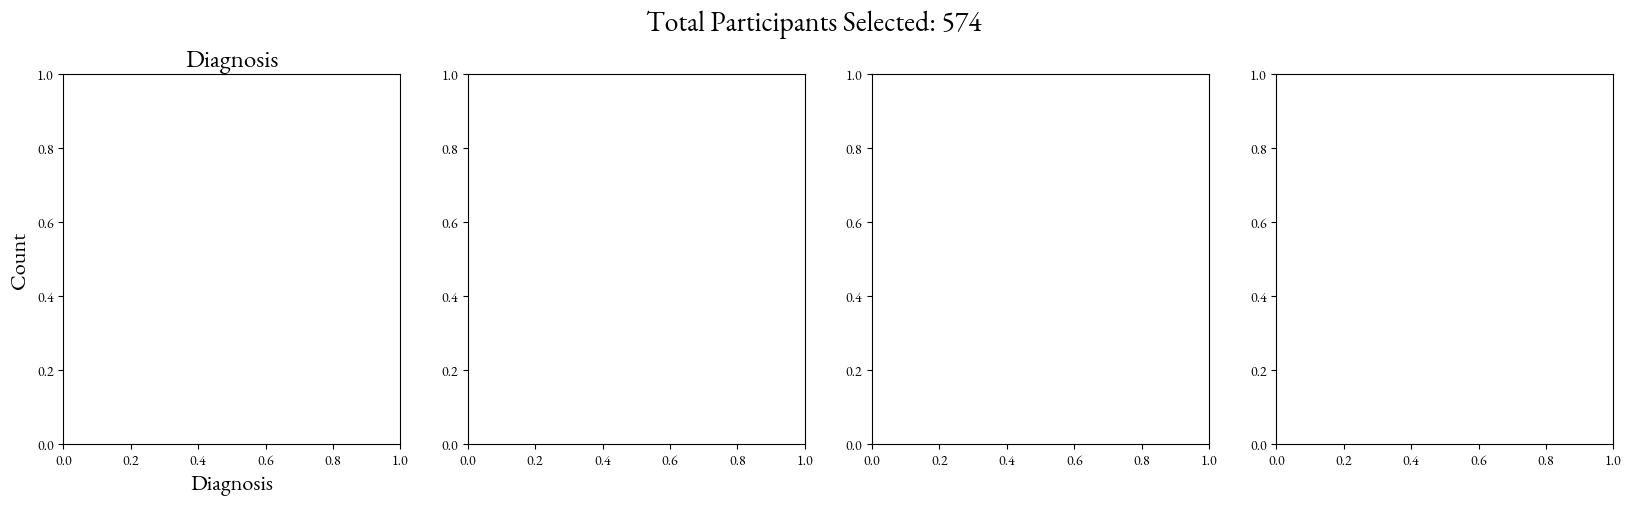

In [19]:
class TabIndex(Enum):
    BATTERY = 0
    TASK = 1

class REDCapAnalysis:
    # Class constants
    WIDGET_WIDTH = '400px'
    PROGRESS_MAX = 10
    
    def __init__(self, diagnosis_columns, battery_columns, battery_breakdown_path):
        # Initialize widgets
        self._initialize_widgets(diagnosis_columns)
        
        # Initialize diagnosis dropdown observers
        self.diagnosis_dropdown_tab1.observe(self.update_checkboxes, names='value')
        self.diagnosis_dropdown_tab2.observe(self.update_checkboxes, names='value')
        
        # Initialize data-related instance variables
        self._initialize_data_related_vars(battery_columns, battery_breakdown_path)
        
        # Display widgets
        self._display_widgets()

        # Initialize data and plots for tab2
        self._update_tab(TabIndex.TASK)

    def _initialize_widgets(self, diagnosis_columns):
        self.token_input = widgets.Password(
            value='',
            placeholder='Enter REDCap token',
            description='Data Token:',
            disabled=False,
            layout=widgets.Layout(width=self.WIDGET_WIDTH)
        )
        self.submit_token = widgets.Button(
            description='Submit',
            disabled=False,
            tooltip='Submit REDCap token',
            icon='check'
        )
        self.csv_path_input = widgets.Text(
            value='',
            placeholder='Enter CSV path',
            description='CSV Path:',
            disabled=True,  # Initially disabled
            layout=widgets.Layout(width=self.WIDGET_WIDTH)
        )
        self.submit_csv = widgets.Button(
            value=False,
            description='Submit',
            disabled=False,
            button_style='',
            tooltip='Use CSV path instead of REDCap token',
            icon='check'
        )
        self.progress_description = widgets.Label(
            value='',
            layout=widgets.Layout(width='100px')
        )
        self.progress = widgets.IntProgress(
            value=0,
            min=0,
            max=self.PROGRESS_MAX,
            step=1,
            bar_style='',
            orientation='horizontal'
        )
        self.diagnosis_dropdown_tab1 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )
        self.diagnosis_dropdown_tab2 = widgets.Dropdown(
            options=diagnosis_columns,
            value='All Children',
            description='Diagnosis Type:',
            disabled=False,
        )

        # Initialize output widgets
        self.out_checkbox_battery = widgets.Output()
        self.out_checkbox_task = widgets.Output()
        self.out_plot_battery = widgets.Output()
        self.out_plot_task = widgets.Output()
        
        # Tab widgets
        self.battery_tab = widgets.VBox([self.diagnosis_dropdown_tab1, self.out_checkbox_battery, self.out_plot_battery])
        self.task_tab = widgets.VBox([self.diagnosis_dropdown_tab2, self.out_checkbox_task, self.out_plot_task])

        self.tabs = widgets.Tab(children=[self.battery_tab, self.task_tab])
        self.tabs.set_title(0, 'Battery Completion')
        self.tabs.set_title(1, 'Task Completion')
        
        # Observe button clicks
        self.submit_token.on_click(self.get_data_from_token)
        self.submit_csv.on_click(self.get_data_from_csv)

    def _initialize_data_related_vars(self, battery_columns, battery_breakdown_path):
        self.diagnosis_checkboxes = {}
        self.task_checkboxes = {}
        self.battery_checkboxes = {}
        self.battery_columns = battery_columns
        self.battery_breakdown_path = battery_breakdown_path
    
    def _display_widgets(self):
        display(widgets.HBox([
            self.token_input, 
            self.submit_token,  # Display toggle button
            self.csv_path_input,  # Display CSV path input
            self.submit_csv,  # Display toggle button
            self.progress_description, 
            self.progress]))
        display(self.tabs)

    def get_data_from_token(self, button):
        self.progress.value = 0
        self.progress.max = 10
        self.progress_description.value = 'Starting...'

        # Fetch data using REDCap token
        token = self.token_input.value
        self.progress.value += 1
        self.progress_description.value = 'Token received...'

        self.redcap_labels = import_data_redcap(token, data='label', headers='label')
        self.progress.value += 3
        self.progress_description.value = 'Label data fetched...'

        self.redcap_raw = import_data_redcap(token, data='raw', headers='raw')
        self.progress.value += 3
        self.progress_description.value = 'Raw data fetched...'

        # Clear token for security reasons
        del token

        self.progress.value = self.progress.max
        self.progress_description.value = 'All done. Nice!'
        
        self.post_data_fetch_operations()
        
        display(self.redcap_labels)

    def get_data_from_csv(self, button):
        self.progress.value = 0
        self.progress.max = 10
        self.progress_description.value = 'Starting...'

        # Fetch data from CSV files
        csv_path = self.csv_path_input.value
        label_csv_path = [f for f in os.listdir(csv_path) if re.search('labels', f, re.IGNORECASE)][0]
        self.redcap_labels = pd.read_csv(label_csv_path)  # Update based on your actual filename
        self.progress.value += 3
        self.progress_description.value = 'Label data loaded from CSV...'

        raw_csv_path = [f for f in os.listdir(csv_path) if re.search('labels', f, re.IGNORECASE)][0]
        self.redcap_raw = pd.read_csv(raw_csv_path)  # Update based on your actual filename
        self.progress.value += 3
        self.progress_description.value = 'Raw data loaded from CSV...'

        self.progress.value = self.progress.max
        self.progress_description.value = 'All done. Nice!'
        
        self.post_data_fetch_operations()

        #     # Fetch data from CSV files
        #     label_csv_path = '/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/DyslexiaProject_VISITONE-PHENO_DATA_LABELS_2023-09-11_widget.csv'
        #     raw_csv_path = '/Users/mkersey/Library/CloudStorage/Box-Box/math_cognition_team/projects/ucsfneuroviz/DyslexiaProject_VISITONE-PHENO_DATA_RAW_2023-09-11.csv'

    def post_data_fetch_operations(self):
        # Create a dictionary to map column names to labels
        self.dict_labels = dict(zip(self.redcap_raw.columns.values.tolist(), self.redcap_labels.columns.values.tolist()))
        
        # Add meaningful columns for diagnosis, MRI, and batteries
        df_tmp = self.redcap_raw.copy()
        df_tmp = get_diagnosis(df_tmp)
        df_tmp = get_mri(df_tmp)
        df_tmp = get_batteries(df_tmp)

        # Identify columns in df_tmp that are not in self.redcap_raw
        new_cols = df_tmp.columns.difference(self.redcap_raw.columns)
        
        # Add these columns to self.redcap_labels
        for col in new_cols:
            self.redcap_labels[col] = df_tmp[col]
        # Filter to phenotyping study participants only, and visit one only
        self.redcap_labels = self.redcap_labels[self.redcap_labels[self.dict_labels['project_category']]=='Pediatric Phenotyping']
        self.redcap_labels = self.redcap_labels[self.redcap_labels[self.dict_labels['redcap_event_name']]=='Visit One']

        # Read in the battery breakdown spreadsheet
        self.battery_breakdown = pd.read_excel(self.battery_breakdown_path, sheet_name='Sheet1')
        
        # Get the variables of interest
        self.all_checkbox_tasks = self.battery_breakdown[self.battery_breakdown['Checkbox']=='YES']['Redcap Variable Name'].values.tolist()
        self.primary_battery_pheno_tasks = self.battery_breakdown[self.battery_breakdown['Primary Phenotyping Battery (Pediatric)']=='YES']['Redcap Variable Name'].values.tolist()
        self.primary_battery_control_tasks = self.battery_breakdown[self.battery_breakdown['Primary Control Battery (Pediatric)']=='YES']['Redcap Variable Name'].values.tolist()

        cols_for_pheno_tasks = []
        cols_for_control_tasks = []

        # Get the column names for primary_battery_pheno_tasks from dict_labels
        for task in self.primary_battery_pheno_tasks:
            if task in self.dict_labels:  # Check if the key exists in the dictionary
                cols_for_pheno_tasks.append(self.dict_labels[task])

        # Get the column names for primary_battery_control_tasks from dict_labels
        for task in self.primary_battery_control_tasks:
            if task in self.dict_labels:  # Check if the key exists in the dictionary
                cols_for_control_tasks.append(self.dict_labels[task])

        # Add new columns based on the condition
        self.redcap_labels['Primary Phenotyping Battery\n(Pediatric)'] = \
            self.redcap_labels[cols_for_pheno_tasks].apply(lambda row: 'Yes' if row.notna().all() else 'No', axis=1)

        self.redcap_labels['Primary Control Battery\n(Pediatric)'] = \
            self.redcap_labels[cols_for_control_tasks].apply(lambda row: 'Yes' if row.notna().all() else 'No', axis=1)
        
        self.update_checkboxes({'new': self.diagnosis_dropdown_tab1.value})
        self.plot_stats({'new': self.diagnosis_dropdown_tab1.value, 'owner': self.diagnosis_dropdown_tab1})

        self.update_checkboxes({'new': self.diagnosis_dropdown_tab2.value})
        self.plot_stats({'new': self.diagnosis_dropdown_tab2.value, 'owner': self.diagnosis_dropdown_tab2})

    def _update_tab(self, tab_index):
        """
        Function to update tab based on tab index.
        """
        if tab_index == TabIndex.BATTERY:
            # Handle updates for Battery Completion tab
            change_dict = {'new': self.diagnosis_dropdown_tab1.value, 'owner': self.diagnosis_dropdown_tab1}
            self.update_checkboxes(change_dict)
            self.plot_stats(change_dict)
            
        elif tab_index == TabIndex.TASK:
            # Handle updates for Task Completion tab
            change_dict = {'new': self.diagnosis_dropdown_tab2.value, 'owner': self.diagnosis_dropdown_tab2}
            self.update_checkboxes(change_dict)
            self.plot_stats(change_dict)
            
        else:
            # Log or print error message, if needed
            print(f"Invalid tab index {tab_index}")

    def _create_checkboxes(self, unique_values, checkbox_layout):
        checkboxes = [widgets.Checkbox(value=False, description=str(val), layout=checkbox_layout) for val in unique_values]
        for checkbox in checkboxes:
            checkbox.observe(self.plot_stats, names='value')
        return checkboxes

    def update_checkboxes(self, change):
        print('update_checkboxes called')
        # Early exit if redcap_labels is not available
        if not hasattr(self, 'redcap_labels'):
            return

        self.out_checkbox_battery.clear_output(wait=True)
        self.out_checkbox_task.clear_output(wait=True)

        # Extract triggering_widget and selected_diagnosis_column
        triggering_widget = change.get('owner', None)
        selected_diagnosis_column = change.get('new', None)

        # Identify the active tab
        active_tab_index = self.tabs.selected_index  # Get the index of the active tab
        out_checkbox = self.out_checkbox_battery if active_tab_index == TabIndex.BATTERY else self.out_checkbox_task

        if active_tab_index == TabIndex.BATTERY:
            additional_columns = self.battery_columns
            checkboxes_dict = self.battery_checkboxes
        elif active_tab_index == TabIndex.TASK:
            additional_columns = ['MRI Acquired']
            checkboxes_dict = self.task_checkboxes
        else:
            return

        all_columns_boxes = []
        checkbox_layout = widgets.Layout(margin='0 0 0 -80px')

        # Create diagnosis checkboxes
        if selected_diagnosis_column != "All Children":
            unique_values = self.redcap_labels[selected_diagnosis_column].dropna().unique()
            diagnosis_checkboxes = self._create_checkboxes(unique_values, checkbox_layout)
            diagnosis_label = widgets.Label(value='Diagnosis')
            diagnosis_box = widgets.VBox([diagnosis_label, widgets.VBox(diagnosis_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
            all_columns_boxes.append(diagnosis_box)
            self.diagnosis_checkboxes[selected_diagnosis_column] = diagnosis_checkboxes

        # Create additional checkboxes
        for col in additional_columns:
            unique_values = self.redcap_labels[col].dropna().unique()
            additional_checkboxes = self._create_checkboxes(unique_values, checkbox_layout)
            col_label = widgets.Label(value=f"{col}")
            col_box = widgets.VBox([col_label, widgets.VBox(additional_checkboxes)], layout=widgets.Layout(align_items='flex-start'))
            all_columns_boxes.append(col_box)
            checkboxes_dict[col] = additional_checkboxes

        with out_checkbox:
            display(widgets.HBox(all_columns_boxes, layout=widgets.Layout(align_items='flex-start')))

    # Helper function to set up individual plots
    def _setup_plot(self, ax, title, x_label, y_label):
        ax.set_title(title, fontsize=18)
        ax.set_xlabel(x_label, fontsize=16)
        ax.set_ylabel(y_label, fontsize=16)

    def filter_data(self, active_tab_index, diagnosis_dropdown_value, selected_battery_values, selected_task_values):
        if diagnosis_dropdown_value == "All Children":
            df_filtered = self.redcap_labels.copy()
        else:
            selected_diagnoses = [cb.description for cb in self.diagnosis_checkboxes.get(diagnosis_dropdown_value, []) if cb.value]
            if not selected_diagnoses:
                return None
            df_filtered = self.redcap_labels[self.redcap_labels[diagnosis_dropdown_value].isin(selected_diagnoses)]
            df_filtered = df_filtered[df_filtered[diagnosis_dropdown_value].notna()]

        if active_tab_index == TabIndex.BATTERY:
            # Filter by battery checkboxes
            for col in self.battery_checkboxes.keys():
                selected_values = selected_battery_values[col]
                if selected_values:
                    df_filtered = df_filtered[df_filtered[col].isin(selected_values)]
                    df_filtered = df_filtered[df_filtered[col].notna()]

        elif active_tab_index == TabIndex.TASK:
            # Filter by battery checkboxes first
            for col in self.battery_checkboxes.keys():
                selected_values = selected_battery_values[col]
                if selected_values:
                    df_filtered = df_filtered[df_filtered[col].isin(selected_values)]
                    df_filtered = df_filtered[df_filtered[col].notna()]

            for category in self.task_checkboxes.keys():
                selected_values = selected_task_values.get(category, [])
                if selected_values:
                    df_filtered = df_filtered[df_filtered[selected_values].notna().all(axis=1)]

        print("Filtered data shape:", df_filtered.shape)  # Debugging line

        return df_filtered

    # Helper function to annotate bars in plots
    def _annotate_bars(self, ax):
        for p in ax.patches:
            ax.annotate(
                str(p.get_height()), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 8), 
                textcoords='offset points',
                fontsize=14
            )

    # Main function for plotting statistics
    def plot_stats(self, change=None):

        # Early exit if redcap_labels is not available
        if not hasattr(self, 'redcap_labels'):
            return
        
        print('plot_stats called')
        print("Data used for plotting:")
        display(self.redcap_labels)  # Debugging line

        # Identify the active tab and set corresponding variables
        active_tab_index = self.tabs.selected_index  # Get the index of the active tab
        out_plot = self.out_plot_battery if active_tab_index == TabIndex.BATTERY else self.out_plot_task
        diagnosis_dropdown_value = self.diagnosis_dropdown_tab1.value if active_tab_index == TabIndex.BATTERY else self.diagnosis_dropdown_tab2.value
        selected_battery_values = {col: [cb.description for cb in cbs if cb.value] for col, cbs in self.battery_checkboxes.items()}
        selected_task_values = {category: [cb.description for cb in cbs if cb.value] for category, cbs in self.task_checkboxes.items()} if active_tab_index == TabIndex.TASK else {}
        
        df_filtered = self.filter_data(active_tab_index, diagnosis_dropdown_value, selected_battery_values, selected_task_values)
        print(df_filtered.head())

        if df_filtered is None or df_filtered.shape[0] == 0:
            # Display a message and return if no subjects are found
            with self.out_plot_battery if active_tab_index == TabIndex.BATTERY else self.out_plot_task:
                print("No subjects found with the selected criteria.")
            return
        
        with out_plot:
            out_plot.clear_output(wait=True)
            
            # Create figure and axes
            fig, ax = plt.subplots(1, 4, figsize=(20, 5))

            # Add supertitle and padding
            fig.suptitle(f'Total Participants Selected: {df_filtered.shape[0]}', fontsize=20)
            fig.subplots_adjust(top=.85)

            # Plot Diagnosis
            self._setup_plot(ax[0], 'Diagnosis', 'Diagnosis', 'Count')
            sns.countplot(data=df_filtered, x=diagnosis_dropdown_value, ax=ax[0], zorder=1)
            self._annotate_bars(ax[0])

            # Plot Age
            self._setup_plot(ax[1], 'Age', 'Age', '')
            sns.countplot(data=df_filtered, x=self.dict_labels['age_neuropsych_int'], ax=ax[1], zorder=1)
            self._annotate_bars(ax[1])

            # Plot Sex
            self._setup_plot(ax[2], 'Sex', 'Sex', '')
            sns.countplot(data=df_filtered, x=self.dict_labels['sex'], ax=ax[2], order=['Male', 'Female', 'Other'], zorder=1)
            self._annotate_bars(ax[2])

            # Plot Handedness
            self._setup_plot(ax[3], 'Handedness', 'Handedness', '')
            sns.countplot(data=df_filtered, x=self.dict_labels['handedness'], ax=ax[3], order=['Right', 'Non-Right', 'Unknown'], zorder=1)
            self._annotate_bars(ax[3])

            # Add horizontal grid lines
            for subplot in ax:
                for ytick in subplot.get_yticks():
                    subplot.axhline(ytick, linestyle='-', alpha=0.25, color='grey', zorder=0)

            # Add note at the bottom
            fig.text(0.1, -0.05, 'Note: Pediatric Phenotyping Study - Visit One', fontsize=14)

            plt.show()

# Now call the class to create the interactive plot
# List of diagnosis columns to choose from
diagnosis_columns = ['All Children', 'Diagnosis Overall', 'Dyslexia and ADHD', 'Dyslexia Phenotype', 'Dyslexia Phenotype Short', 'Dyslexia and Dyscalculia', 'Dyslexia and MLD', 'MLD Subtype Primary', 'MLD Subtype Secondary']
battery_columns = ['MRI Acquired', 'Primary Phenotyping Battery\n(Pediatric)', 'Primary Control Battery\n(Pediatric)']

# Load in battery breakdown spreadsheet
battery_breakdown_path = '/Users/mkersey/Library/CloudStorage/Box-Box/Dyslexia RC Documents/Administering, Testing Stimuli, Scoring/Full_List_of_Batteries_and_Tests.xlsx'

# Create an instance of REDCapAnalysis with the list of diagnosis columns
redcap_analysis = REDCapAnalysis(diagnosis_columns, battery_columns, battery_breakdown_path)